# Segmentation Algorithm Demo for TTN - Cardio

----------------------------------------
description of the structure 

----------------------------------------

Also, we may add a picture of the corresponding row in the lookup table for readers to correlate this notebook with a specifc row in the lookup table.


----------------------------------------
PLACEHOLDER: description of the functions to be used, and the usage of each parameters

----------------------------------------


In [1]:
import numpy as np

# package for 3d visualization
from itkwidgets import view                              
from aicssegmentation.core.visual import seg_fluo_side_by_side,  single_fluorescent_view, segmentation_quick_view
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 12]

# package for io 
from aicsimageio import AICSImage, omeTifWriter                            

# function for core algorithm
from aicssegmentation.core.vessel import vesselness3D
from aicssegmentation.pre_processing_utils import intensity_normalization, boundary_preserving_smoothing_3d
from skimage.morphology import remove_small_objects     # function for post-processing (size filter)
from aicssegmentation.core.visual import explore_vesselness_3d

ImportError: No module named '_czifile'. Decoding of JXR and JPEG encoded images will not be available. Czifile.pyx can be obtained at http://www.lfd.uci.edu/~gohlke/


## Loading the data

In [2]:
FILE_NAME = '/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/TTN/original/20180322_M06_001-Scene-03-P3-C03.tif'
reader = AICSImage(FILE_NAME) 
IMG = reader.data

print(IMG.shape)

(1, 4, 60, 1300, 1900)


## Preview of the image

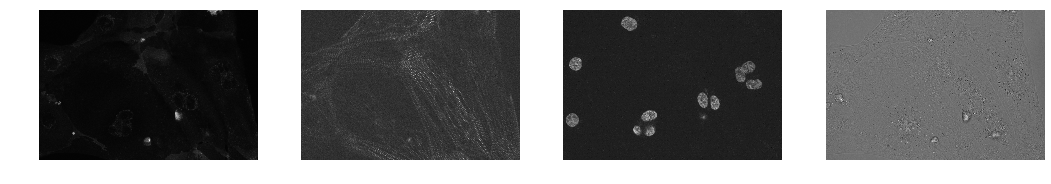

In [3]:
N_CHANNELS = IMG.shape[1]
MID_SLICE = np.int(0.5*IMG.shape[2])

fig, ax = plt.subplots(1, N_CHANNELS, figsize=(18,16), dpi=72, facecolor='w', edgecolor='k')
for channel in range(N_CHANNELS):
    ax[channel].axis('off')
    ax[channel].imshow(IMG[0,channel,MID_SLICE,:,:], cmap=plt.cm.gray)

## Image segmentation

### Step 1: Pre-Processing

In [11]:
################################
## PARAMETERS for this step ##
structure_channel = 1
intensity_scaling_param = [8, 15.5]
gaussian_smoothing_sigma = 1
################################

structure_img0 = IMG[0,structure_channel,:,:,:]

# intensity normalization
structure_img = intensity_normalization(structure_img0, scaling_param=intensity_scaling_param)

# smoothing with 2d gaussian filter slice by slice 
structure_img_smooth = boundary_preserving_smoothing_3d(structure_img)

intensity normalization: normalize into [mean - 8 x std, mean + 15.5 x std] 
intensity normalization completes


In [14]:
view(single_fluorescent_view(structure_img_smooth))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f41f3e959…

#### If the contrast looks too off, you can play with the normalization parameters

In [5]:
from aicssegmentation.pre_processing_utils import suggest_normalization_param

In [10]:
np.count_nonzero(structure_img0<100)

600973

In [6]:
suggest_normalization_param(structure_img0)

122.85982591093118
14.475985944038968
344.0
0
734
suggested upper range is 15.5, which is 347.2376080435352
suggested upper range is 8.0, which is 7.051938358619438
So, suggested parameter for normalization is [8.0, 15.5]
You may also increase the first value (may loss some dim parts), or decrease the second value (may loss some texture in super bright regions) to further enhance the contrast


In [11]:
# test new parameters

################################
intensity_scaling_param = [1.5, 8.0]
gaussian_smoothing_sigma = 1
################################

# intensity normalization
structure_img = intensity_normalization(structure_img0, scaling_param=intensity_scaling_param)

# smoothing 
structure_img_smooth = boundary_preserving_smoothing_3d(structure_img)

view(single_fluorescent_view(structure_img_smooth))

intensity normalization: normalize into [mean - 1.5 x std, mean + 8.0 x std] 
intensity normalization completes


Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fd71a4098…

### Step 2: Core Algorithm

#### Run with default parameters as in Look-up Table

In [12]:
################################
## PARAMETERS for this step ##
vesselness_sigma = [1]
vesselness_cutoff = 0.01
################################

response = vesselness3D(structure_img_smooth, sigmas=vesselness_sigma,  tau=1, whiteonblack=True)
bw = response > vesselness_cutoff

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


In [15]:
view(segmentation_quick_view(response > 0.02))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f41f3e9…

In [13]:
view(segmentation_quick_view(bw))

Viewer(rendered_image=<itkImagePython.itkImageUC3; proxy of <Swig Object of type 'itkImageUC3 *' at 0x7f42b6bb…

In [15]:
# Find a region of interest (ROI) in segmentation image above, and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [509,221,669,452]
view(seg_fluo_side_by_side(structure_img,bw,roi=ROI))

# or comment out the following line to see the whole FOV
#view(seg_fluo_side_by_side(structure_img,seg))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7fd6ea34cb…

#### If the segmentation is satisfactory, go to Step 3; otherwise, you can tune parameters to improve the performance. Follow the steps below:

--------------------------
Placeholder:  Describe the effect of each parameter

------------------------------

In [16]:
# find a small region of interest, 
# type in below the coordinates of upper left corner and lower right corner of the ROI
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [393, 86,595,305]
view(explore_vesselness_3d(structure_img_smooth, sigma=[0.5, 2], th=0.15, roi=ROI))

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f50892cd6…

#### Now, if you have found a satisfatory set of parameters, type in the parameters below and re-run the segmentation. Then, move to step 3

In [17]:
# type in parameters here:
################################
## PARAMETERS for this step ##
vesselness_sigma = [0.5,2]
vesselness_cutoff = 0.15
################################

response = vesselness3D(structure_img_smooth, sigmas=vesselness_sigma,  tau=1, whiteonblack=True)
bw = response > vesselness_cutoff

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


#### Step 3: Post-Processing 

In [19]:
################################
## PARAMETERS for this step ##
minArea = 4
################################

final_seg = remove_small_objects(bw>0, min_size=minArea, connectivity=1, in_place=False)

## Result inspection

In [17]:
view(seg_fluo_side_by_side(structure_img,SEG))

Viewer(rendered_image=<itkImagePython.itkImageF3; proxy of <Swig Object of type 'itkImageF3 *' at 0x7f2b44072c…

### You can also focus your inspection on a small ROI

In [ ]:
# Find ROI in segmentation image above (not the raw image on the right part), and then type in ROI below
# in the form of [Upper_Left_X, Upper_Left_Y, Lower_right_X, Lower_right_Y]
ROI = [244, 361, 441, 562]
view(seg_fluo_side_by_side(structure_img,SEG, roi=ROI))

### You may also physically save the segmentation results into a ome.tif file

In [27]:
SEG= SEG>0
out=SEG.astype(np.uint8)
out[out>0]=255
writer = omeTifWriter.OmeTifWriter('/allen/aics/assay-dev/Segmentation/documentation/toolkit_paper/structures/DSP/test1.ome.tif')
writer.save(out)